In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import re
from datetime import datetime
import random

In [3]:
class FailureManager:

    def __init__(self):
        self.user_trace = None

    def analyze_failure(self, file):    
        if file is not None:
            with open(file, 'rb') as fin:
                self.user_trace = pickle.load(fin)
            self.user_trace_keys = list(self.user_trace.keys())

In [4]:
my_file = '/Users/riksanyal/Desktop/FedScale/benchmark/dataset/data/device_info/client_behave_trace'

In [5]:
fm = FailureManager()
fm.analyze_failure(my_file)

In [6]:
print(len(fm.user_trace), len(fm.user_trace_keys))

107749 107749


In [7]:
def extract_timestamps(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    start_phrase = "==== started _train_epoch train()"
    end_phrase = "==== completed _train_epoch train()"

    start_timestamps = []
    end_timestamps = []
    started = False

    for i, line in enumerate(lines):
        if start_phrase in line:
            # Extract time (without date) from the previous line
            timestamp = re.findall(r'\d{2}:\d{2}:\d{2},\d{3}', lines[i - 2])
            if timestamp:
                start_timestamps.append(timestamp[0])
            started = True
        elif end_phrase in line and started:
            # Extract time (without date) from the next line
            timestamp = re.findall(r'\d{2}:\d{2}:\d{2},\d{3}', lines[i + 1])
            if timestamp:
                end_timestamps.append(timestamp[0])
            started = False

    return start_timestamps, end_timestamps

In [8]:
start_ts, end_ts = extract_timestamps('/Users/riksanyal/Desktop/asyncfl_logs_26Nov/trainer1_logs.txt')

print("Start Timestamps:", start_ts)
print("End Timestamps:", end_ts)

Start Timestamps: ['00:27:45,624', '00:28:18,468', '00:29:04,836', '00:29:51,364', '00:30:10,957', '00:30:24,824', '00:30:44,806', '00:31:03,557', '00:31:30,290', '00:32:03,665', '00:32:22,595', '00:32:49,513']
End Timestamps: ['00:27:48,656', '00:28:20,841', '00:29:07,211', '00:29:53,554', '00:30:13,425', '00:30:27,139', '00:30:47,223', '00:31:05,782', '00:31:32,472', '00:32:05,983', '00:32:24,959', '00:32:51,915']


In [9]:
time_diff = []
for i in range(len(end_ts)):
    time_diff.append(datetime.strptime(end_ts[i], "%H:%M:%S,%f")-datetime.strptime(start_ts[i], "%H:%M:%S,%f"))

In [10]:
np.mean(time_diff)

datetime.timedelta(seconds=2, microseconds=388417)

In [11]:
idle_diff = []
for i in range(len(end_ts)-1):
    idle_diff.append(datetime.strptime(start_ts[i+1], "%H:%M:%S,%f")-datetime.strptime(end_ts[i], "%H:%M:%S,%f"))

In [12]:
np.mean(idle_diff)

datetime.timedelta(seconds=25, microseconds=239091)

In [13]:
user_trace = None if fm.user_trace is None else fm.user_trace[fm.user_trace_keys[83811]]

In [14]:
user_trace

{'duration': 31255,
 'inactive': [244186, 244195, 245232, 245254, 246881, 247938, 290033],
 'finish_time': 345600,
 'active': [243833, 244190, 244224, 245236, 245343, 247548, 262090],
 'model': 'SM-A300H'}

In [15]:
inactive = user_trace['inactive']
active = user_trace['active']

('Active', 243833, 244186)
('Inactive', 244186, 244190)
('Active', 244190, 244195)
('Inactive', 244195, 244224)
('Active', 244224, 245232)
('Inactive', 245232, 245236)
('Active', 245236, 245254)
('Inactive', 245254, 245343)
('Active', 245343, 246881)
('Inactive', 246881, 247548)
('Active', 247548, 247938)
('Inactive', 247938, 262090)
('Active', 262090, 290033)


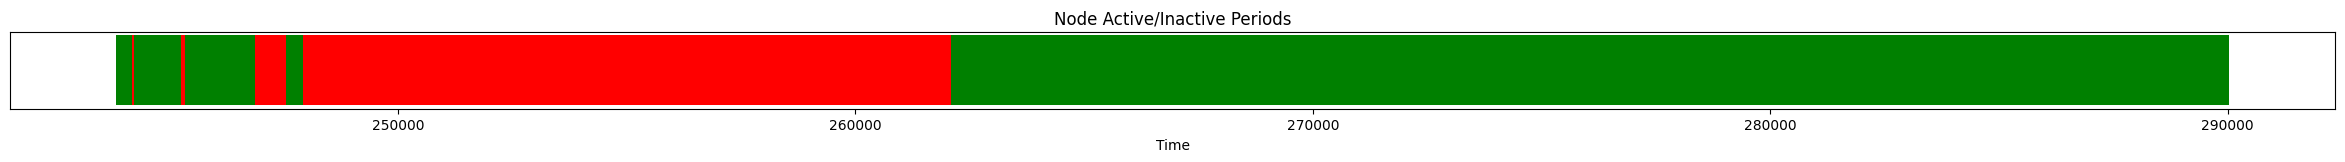

In [16]:
periods = []
for i in range(len(active)):
    # Assuming each active timestamp is followed by an inactive one
    periods.append(('Active', active[i], inactive[i]))
    if i < len(active) - 1:  # To avoid index out of range
        periods.append(('Inactive', inactive[i], active[i+1]))

# Visualization
fig, ax = plt.subplots(figsize=(30, 1))

for period in periods:
    print(period)
    if period[0] == 'Active':
        color = 'green'
    else:
        color = 'red'
    ax.broken_barh([(period[1], period[2]-period[1])], (0, 1), facecolors=color)

# Improve the appearance
ax.set_yticks([])
ax.set_xlabel('Time')
# plt.xticks(rotation=45)
plt.title('Node Active/Inactive Periods')

plt.show()


In [17]:
def trace_periods(key):
    user_trace = None if fm.user_trace is None else fm.user_trace[fm.user_trace_keys[key]]
    inactive = user_trace['inactive']
    active = user_trace['active']

    periods = []
    for i in range(len(active)):
        # Assuming each inactive timestamp is followed by an active one
        periods.append(('Active', active[i], inactive[i]))
        if i < len(active) - 1:  # To avoid index out of range
            periods.append(('Inactive', inactive[i], active[i+1]))
    
    return periods

In [23]:
# sample 1000 out of the 100k keys in the user_trace_keys
random.seed(42)
sampled_keys = random.sample(fm.user_trace_keys, 1000)
# sampled_keys.append(0)

In [28]:
key_count=0
all_count_cases = []
for key in sampled_keys:
    key_count+=1
    # print("key_count: ", key_count, "; key: ", key)
    periods = trace_periods(key)
    training_start_times = np.arange(0, int(periods[-1][2]), 30.63)
    count_cases = 0
    for start_time in training_start_times:
        for i in range(len(periods)):
            if periods[i][0] == 'Active':
                if (periods[i][1] <= start_time <= periods[i][2]):
                    end_time = start_time + 5.39
                    for j in range(i+1,len(periods)):
                        if periods[j][0] == 'Inactive':
                            if (periods[j][1] <= end_time <= periods[j][2]):
                                print("key count: ", key_count, "; start_time: ",start_time, "; end_time: ", end_time, "; active_time", periods[i][2], "; inactive_time", periods[j][1])
                                count_cases += 1
                                break
    
    # print("count_cases: ", count_cases)
    all_count_cases.append(count_cases)

key count:  1 ; start_time:  244182.36 ; end_time:  244187.75 ; active_time 244186 ; inactive_time 244186
key count:  1 ; start_time:  246877.8 ; end_time:  246883.19 ; active_time 246881 ; inactive_time 246881
key count:  4 ; start_time:  100558.29 ; end_time:  100563.68 ; active_time 100560 ; inactive_time 100560
key count:  5 ; start_time:  34366.86 ; end_time:  34372.25 ; active_time 34367 ; inactive_time 34367
key count:  6 ; start_time:  181574.63999999998 ; end_time:  181580.03 ; active_time 181580 ; inactive_time 181580
key count:  7 ; start_time:  308597.25 ; end_time:  308602.64 ; active_time 308601 ; inactive_time 308601
key count:  8 ; start_time:  295640.76 ; end_time:  295646.15 ; active_time 295642 ; inactive_time 295642
key count:  8 ; start_time:  319501.52999999997 ; end_time:  319506.92 ; active_time 319506 ; inactive_time 319506
key count:  8 ; start_time:  323605.95 ; end_time:  323611.34 ; active_time 323609 ; inactive_time 323609
key count:  8 ; start_time:  3474

In [29]:
max_count_cases = max(all_count_cases)
print(max_count_cases,(max_count_cases/len(training_start_times))*100)

28 0.1767899987372143


In [ ]:
# plot histogram of count_cases

In [100]:
training_start_times = np.arange(0, periods[-1][2], 27.63)

In [101]:
len(training_start_times)

39157

In [102]:
count_cases = 0
for start_time in training_start_times:
    for i in range(len(periods)):
        if periods[i][0] == 'Active':
            if (periods[i][1] <= start_time <= periods[i][2]):
                end_time = start_time + 2.39
                for j in range(i+1,len(periods)):
                    if periods[j][0] == 'Inactive':
                        if (periods[j][1] <= end_time <= periods[j][2]):
                            print("start_time: ",start_time, "; end_time: ", end_time)
                            count_cases += 1
                            break

print(count_cases)

start_time:  59045.31 ; end_time:  59047.7
1


In [85]:
trace_periods(1)[-1][2]

917251